In [3]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted
from helpers.plot_helpers import create_animation_ffmpeg

import hvplot.xarray
import hvplot
import cmocean
import os

%load_ext autoreload
%autoreload 3

# Snapshot

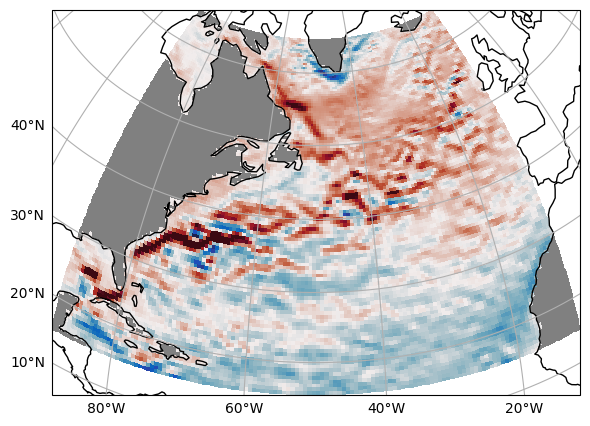

In [46]:
plot(xr.open_dataset(
    '/scratch/pp2681/mom6/CM26_datasets/Filtering(FGR=2)+CoarsenKochkov()/factor-6/train-0.nc').u,
     xr.open_dataset(
     '/scratch/pp2681/mom6/CM26_datasets/CoarsenWeighted()/factor-6/param.nc').wet_u,
     selector=select_NA
    )

# Movies

In [4]:
def read_datasets(operator_str = 'Filtering(FGR=2)+CoarsenKochkov()', factors = [4,6,9,12]): 
    d = {}
    for factor in factors:
        for key in ['train', 'test']:
            data = xr.open_mfdataset(
                f'/scratch/pp2681/mom6/CM26_datasets/{operator_str}/factor-{factor}/{key}*.nc', chunks={'time':1})
            param = xr.open_mfdataset(
                f'/scratch/pp2681/mom6/CM26_datasets/{operator_str}/factor-{factor}/param.nc')
            d[f'{key}-{factor}'] = DatasetCM26(data, param)
            print(f'Dataset have been read: {operator_str}-{key}-{factor}')
    return d

In [5]:
%time dataset = read_datasets()

Dataset have been read: Filtering(FGR=2)+CoarsenKochkov()-train-4
Dataset have been read: Filtering(FGR=2)+CoarsenKochkov()-test-4
Dataset have been read: Filtering(FGR=2)+CoarsenKochkov()-train-6
Dataset have been read: Filtering(FGR=2)+CoarsenKochkov()-test-6
Dataset have been read: Filtering(FGR=2)+CoarsenKochkov()-train-9
Dataset have been read: Filtering(FGR=2)+CoarsenKochkov()-test-9
Dataset have been read: Filtering(FGR=2)+CoarsenKochkov()-train-12
Dataset have been read: Filtering(FGR=2)+CoarsenKochkov()-test-12
CPU times: user 3.99 s, sys: 2.17 s, total: 6.17 s
Wall time: 25.5 s


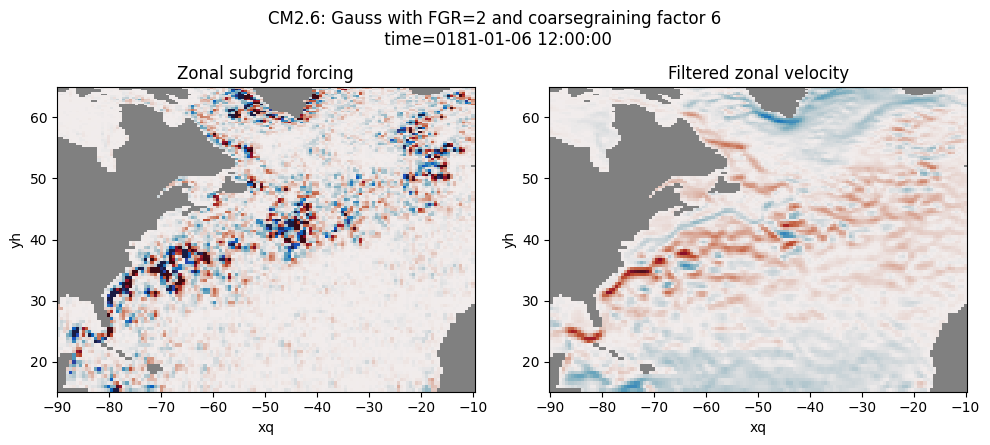

In [6]:
def plot_SGS(idx=1):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plot(dataset['train-6'].data.SGSx.isel(time=idx), dataset['train-6'].param.wet_u, cartopy=False, vmax=1e-6, selector=select_NA)
    plt.title('Zonal subgrid forcing')
    plt.subplot(1,2,2)
    plot(dataset['train-6'].data.u.isel(time=idx), dataset['train-6'].param.wet_u, cartopy=False, vmax=1, selector=select_NA)
    plt.title('Filtered zonal velocity')
    time = dataset['train-6'].data.time.isel(time=idx).data
    plt.suptitle(f'CM2.6: Gauss with FGR=2 and coarsegraining factor 6\n time={time}', y=1.1)
plot_SGS()

In [11]:
#create_animation_ffmpeg(plot_SGS, range(12*15), 'CM26_subgrid.mp4', FPS=12)

In [8]:
ds = DatasetCM26()
ds = ds.split(slice(0,None,5))

In [9]:
def plot_cm(idx=1):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plot(dataset['train-4'].data.u.isel(time=idx), dataset['train-4'].param.wet_u, cartopy=False, vmax=1, selector=select_Cem)
    plt.title('Filtered zonal velocity')
    plt.subplot(1,2,2)
    plot(ds.data.u.isel(time=idx), ds.param.wet_u, cartopy=False, vmax=1, selector=select_Cem)
    plt.title('CM26 original data')
    time = dataset['train-6'].data.time.isel(time=idx).data
    plt.suptitle(f'CM2.6: Gauss with FGR=2 and coarsegraining factor 4\n time={time}', y=1.1)

In [10]:
# create_animation_ffmpeg(plot_cm, range(12*15), 'CM26_coastline.mp4', FPS=12)

# Different filters

In [109]:
def read_plot(key='CoarsenWeighted()', factor=4, field='SGSx',mask='wet_u', vmax=1e-6):
    return plot(
        xr.open_dataset(
            f'/scratch/pp2681/mom6/CM26_datasets/{key}/factor-{factor}/train-0.nc')[field],
             xr.open_dataset(
             f'/scratch/pp2681/mom6/CM26_datasets/{key}/factor-{factor}/param.nc')[mask],
             selector=select_NA, cartopy=False, vmax=vmax
            )

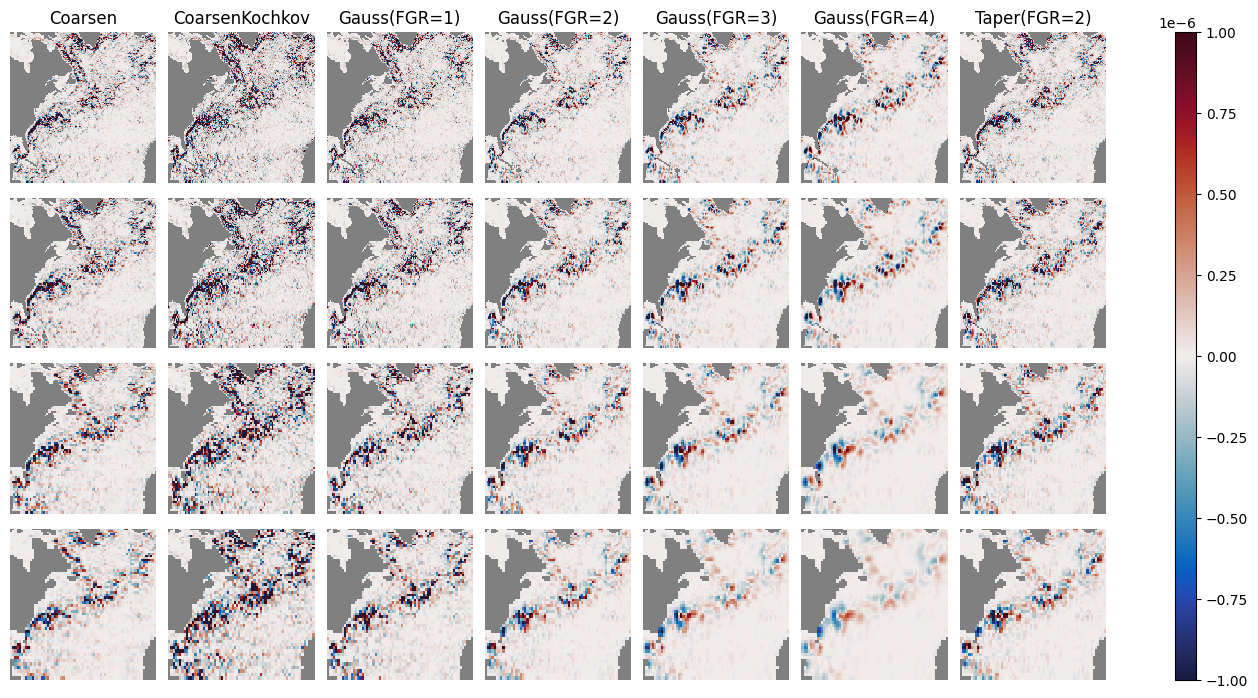

In [107]:
plt.figure(figsize=(14,7))
for col, (op, label) in enumerate(zip([
           'CoarsenWeighted()', 
           'CoarsenKochkov()', 
           'Filtering(FGR=1)+CoarsenKochkov()', 
           'Filtering(FGR=2)+CoarsenKochkov()',
           'Filtering(FGR=3)+CoarsenKochkov()',
           'Filtering(FGR=4)+CoarsenKochkov()',
           'Filtering(FGR=2,shape=gcm_filters.FilterShape.TAPER)+CoarsenKochkov()'
          ],
          ['Coarsen', 'CoarsenKochkov', 'Gauss(FGR=1)', 
           'Gauss(FGR=2)', 'Gauss(FGR=3)', 'Gauss(FGR=4)', 'Taper(FGR=2)'])):
    for row, factor in enumerate([4,6,9,12]):
        plt.subplot(4,7,col+1+row*7)
        im = read_plot(op, factor)
        plt.axis('off')
        if row==0:
            plt.title(label)
        if col==0:
            plt.ylabel(f'Coarse grid factor={factor}')
plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().axes, aspect=30)
plt.savefig('../figures/dataset_SGSx.png', dpi=200)

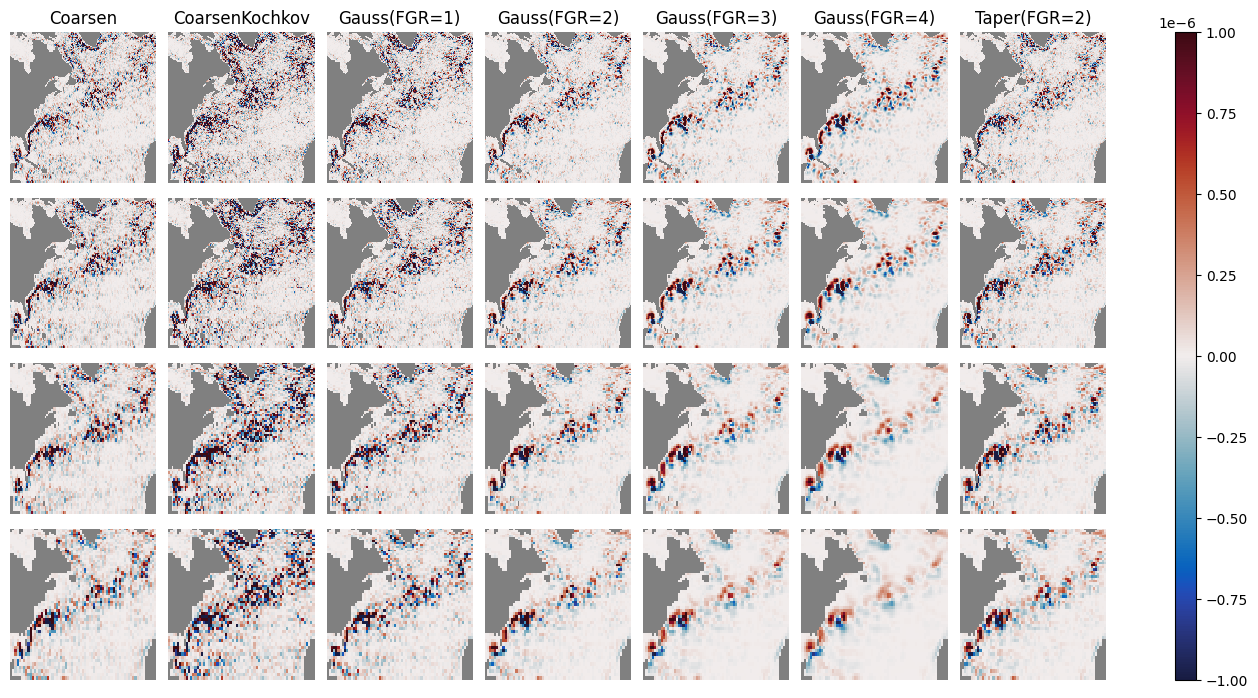

In [106]:
plt.figure(figsize=(14,7))
for col, (op, label) in enumerate(zip([
           'CoarsenWeighted()', 
           'CoarsenKochkov()', 
           'Filtering(FGR=1)+CoarsenKochkov()', 
           'Filtering(FGR=2)+CoarsenKochkov()',
           'Filtering(FGR=3)+CoarsenKochkov()',
           'Filtering(FGR=4)+CoarsenKochkov()',
           'Filtering(FGR=2,shape=gcm_filters.FilterShape.TAPER)+CoarsenKochkov()'
          ],
          ['Coarsen', 'CoarsenKochkov', 'Gauss(FGR=1)', 
           'Gauss(FGR=2)', 'Gauss(FGR=3)', 'Gauss(FGR=4)', 'Taper(FGR=2)'])):
    for row, factor in enumerate([4,6,9,12]):
        plt.subplot(4,7,col+1+row*7)
        im = read_plot(op, factor,'SGSy', 'wet_v')
        plt.axis('off')
        if row==0:
            plt.title(label)
        if col==0:
            plt.ylabel(f'Coarse grid factor={factor}')
plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().axes, aspect=30)
plt.savefig('../figures/dataset_SGSy.png', dpi=200)

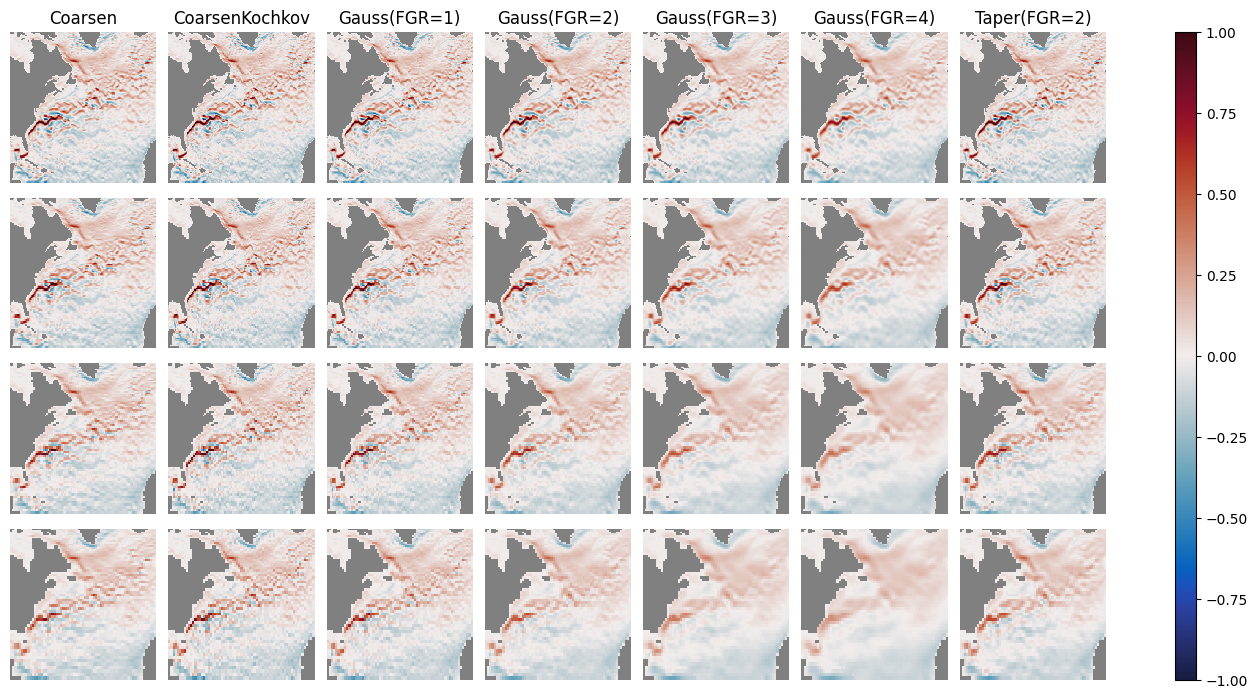

In [110]:
plt.figure(figsize=(14,7))
for col, (op, label) in enumerate(zip([
           'CoarsenWeighted()', 
           'CoarsenKochkov()', 
           'Filtering(FGR=1)+CoarsenKochkov()', 
           'Filtering(FGR=2)+CoarsenKochkov()',
           'Filtering(FGR=3)+CoarsenKochkov()',
           'Filtering(FGR=4)+CoarsenKochkov()',
           'Filtering(FGR=2,shape=gcm_filters.FilterShape.TAPER)+CoarsenKochkov()'
          ],
          ['Coarsen', 'CoarsenKochkov', 'Gauss(FGR=1)', 
           'Gauss(FGR=2)', 'Gauss(FGR=3)', 'Gauss(FGR=4)', 'Taper(FGR=2)'])):
    for row, factor in enumerate([4,6,9,12]):
        plt.subplot(4,7,col+1+row*7)
        im = read_plot(op, factor,'u', 'wet_u', 1)
        plt.axis('off')
        if row==0:
            plt.title(label)
        if col==0:
            plt.ylabel(f'Coarse grid factor={factor}')
plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().axes, aspect=30)
plt.savefig('../figures/dataset_u.png', dpi=200)

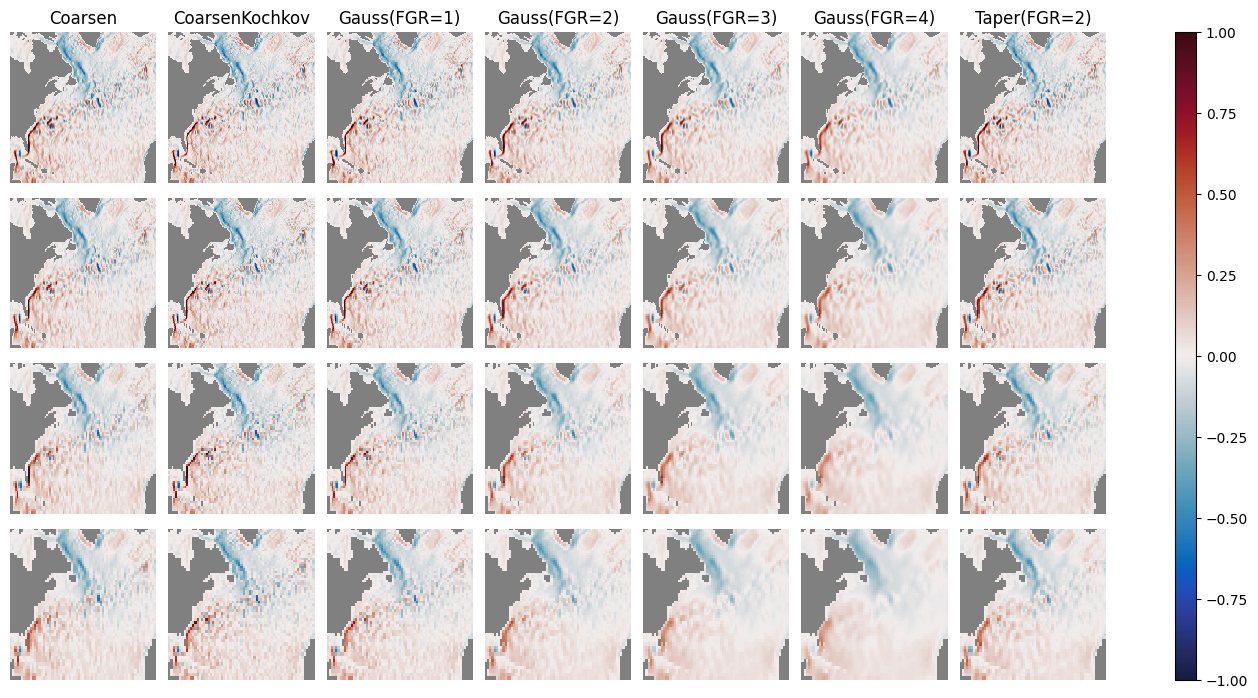

In [112]:
plt.figure(figsize=(14,7))
for col, (op, label) in enumerate(zip([
           'CoarsenWeighted()', 
           'CoarsenKochkov()', 
           'Filtering(FGR=1)+CoarsenKochkov()', 
           'Filtering(FGR=2)+CoarsenKochkov()',
           'Filtering(FGR=3)+CoarsenKochkov()',
           'Filtering(FGR=4)+CoarsenKochkov()',
           'Filtering(FGR=2,shape=gcm_filters.FilterShape.TAPER)+CoarsenKochkov()'
          ],
          ['Coarsen', 'CoarsenKochkov', 'Gauss(FGR=1)', 
           'Gauss(FGR=2)', 'Gauss(FGR=3)', 'Gauss(FGR=4)', 'Taper(FGR=2)'])):
    for row, factor in enumerate([4,6,9,12]):
        plt.subplot(4,7,col+1+row*7)
        im = read_plot(op, factor,'v', 'wet_v', 1)
        plt.axis('off')
        if row==0:
            plt.title(label)
        if col==0:
            plt.ylabel(f'Coarse grid factor={factor}')
plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().axes, aspect=30)
plt.savefig('../figures/dataset_v.png', dpi=200)

Correlation: 0.9480892908127994
Relative Error: 0.36944976449012756
R2 =  0.8988550379872322
R2 max =  0.898876890540123
Optinal scaling: 0.9950939416885376
Nans [test/control]: [0, 0]


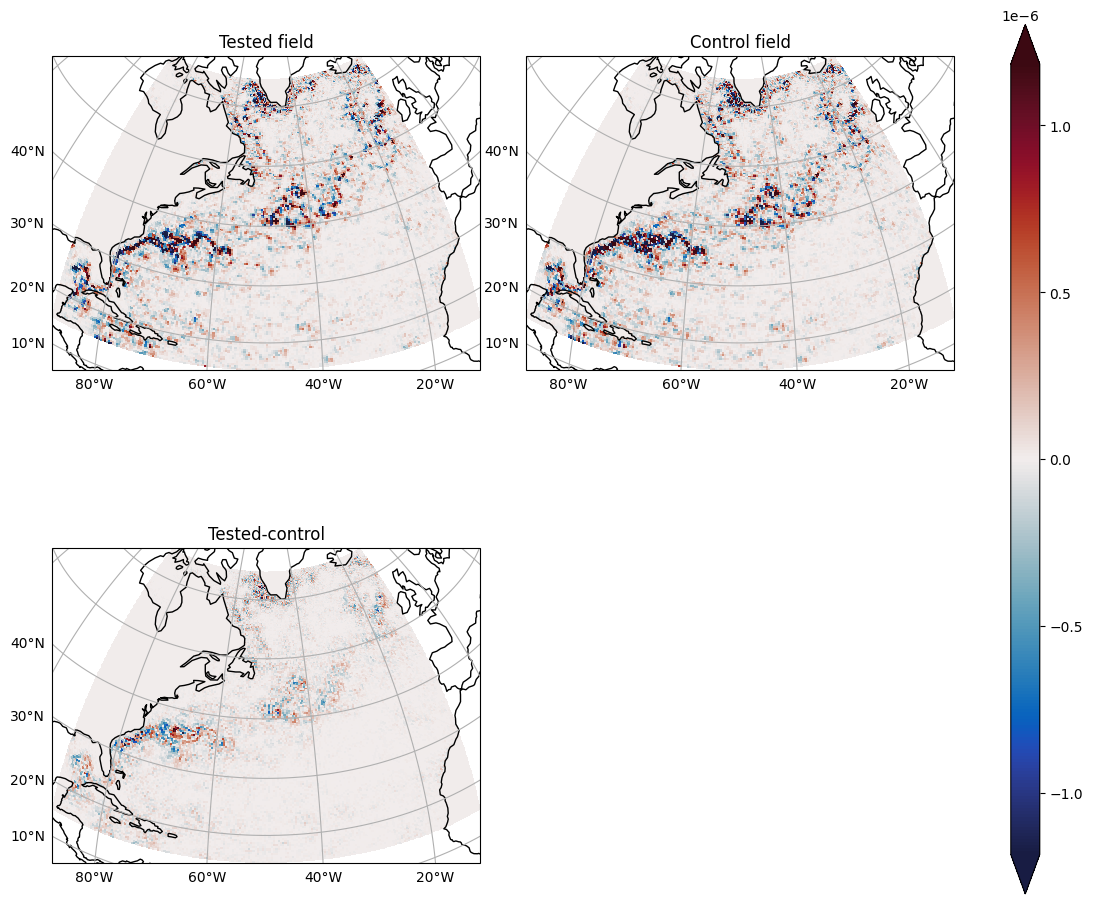

In [128]:
compare(xr.open_dataset(
            f'/scratch/pp2681/mom6/CM26_datasets/Filtering(FGR=2)+CoarsenKochkov()/factor-4/train-0.nc').SGSx,
       xr.open_dataset(
            f'/scratch/pp2681/mom6/CM26_datasets/Filtering(FGR=2,shape=gcm_filters.FilterShape.TAPER)+CoarsenKochkov()/factor-4/train-0.nc').SGSx,
       selector=select_NA)